In [1]:
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.aqua.components.initial_states import Zero
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.components.variational_forms import RY, RYRZ, swaprz
from qiskit import BasicAer
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP
import numpy as np
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms.adaptive import VQE
from qiskit.aqua.algorithms.classical import ExactEigensolver
import pylab
import matplotlib.pyplot as plt

In [2]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.052373245772859}, "label": "II"},
              {"coeff": {"imag": 0.0, "real": 0.39793742484318045}, "label": "ZI"},
              {"coeff": {"imag": 0.0, "real": -0.39793742484318045}, "label": "IZ"},
              {"coeff": {"imag": 0.0, "real": -0.01128010425623538}, "label": "ZZ"},
              {"coeff": {"imag": 0.0, "real": 0.18093119978423156}, "label": "XX"}
              ]
}

qubit_op = WeightedPauliOperator.from_dict(pauli_dict)
num_qubits = qubit_op.num_qubits
print('Number of qubits: {}'.format(num_qubits))

Number of qubits: 2


In [3]:
# using driver to get fermionic Hamiltonian
# PySCF example
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 1.6', unit=UnitsType.ANGSTROM,
                     charge=0, spin=0, basis='sto3g')
molecule = driver.run()

# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order
map_type = 'parity'

h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# of electrons: {}".format(num_particles))
print("# of spin orbitals: {}".format(num_spin_orbitals))

HF energy: -8.854072040283647
# of electrons: 4
# of spin orbitals: 12


In [4]:
# prepare full idx of freeze_list and remove_list
# convert all negative idx to positive
remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
# update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]

# prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
# and if PARITY mapping is selected, reduction qubits
energy_shift = 0.0
qubit_reduction = True if map_type == 'parity' else False

ferOp = FermionicOperator(h1=h1, h2=h2)
if len(freeze_list) > 0:
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
if len(remove_list) > 0:
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)

qubit_op = ferOp.mapping(map_type=map_type)
qubit_op = Z2Symmetries.two_qubit_reduction(qubit_op, num_particles) if qubit_reduction else qubitOp
qubit_op.chop(10**-10)

# print(qubit_op.print_operators())
print(qubit_op)
print(qubit_op.num_qubits)

Representation: paulis, qubits: 4, size: 100
4


In [5]:
num_qubits = qubit_op.num_qubits

init_state_UCCSD = HartreeFock(qubit_op.num_qubits, num_spin_orbitals, num_particles, map_type, 
                       qubit_reduction)
init_state_Zero = Zero(num_qubits)

In [6]:
UCCSD_var_form = UCCSD(num_qubits,depth=1, num_orbitals=num_spin_orbitals,num_particles=num_particles, initial_state=init_state_UCCSD)

In [7]:
UCCSD_var_form.num_parameters

8

In [8]:
## Some code that extract the variational form.  Ideally it will draw it out as well.
init_state = Zero(num_qubits)
var_form = RY(num_qubits, initial_state=init_state_Zero)

In [9]:
backend = BasicAer.get_backend('statevector_simulator')

In [10]:
optimizers = [COBYLA, SLSQP]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
param_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubit_op.num_qubits

for i in range(len(optimizers)):
    aqua_globals.random_seed = 250
    optimizer = optimizers[i](maxiter = 10)
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
    params = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
  
    algo = VQE(qubit_op, UCCSD_var_form, optimizer, callback=store_intermediate_result)
    quantum_instance = QuantumInstance(backend=backend)  
    algo_result = algo.run(quantum_instance)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    param_vals[i] = np.asarray(params)
print('\rOptimization complete      ');

Optimization complete      


### 4.4 Energy convergence
Using a classical computer to compare reasonably sized problems

In [11]:
ee = ExactEigensolver(qubit_op)
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.077059745734694


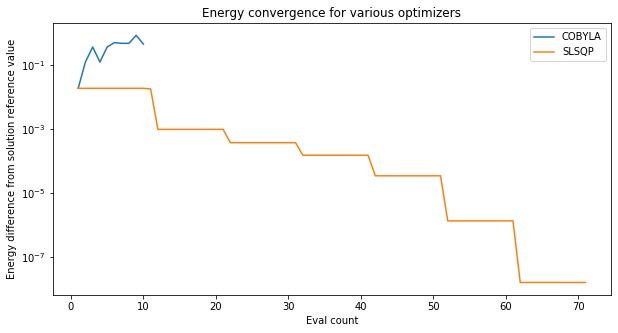

In [12]:
plt.figure(figsize=(10,5))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
plt.xlabel('Eval count')
plt.ylabel('Energy difference from solution reference value')
plt.title('Energy convergence for various optimizers')
plt.yscale('log')
plt.legend(loc='upper right')

In [13]:
optimizers = [COBYLA, SLSQP]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)
param_vals = np.empty([len(optimizers)], dtype=object)
num_qubits = qubit_op.num_qubits

for i in range(len(optimizers)):
    aqua_globals.random_seed = 250
    optimizer = optimizers[i]()
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')

    counts = []
    values = []
    params = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)
        params.append(parameters)
  
    algo = VQE(qubit_op, var_form, optimizer, callback=store_intermediate_result)
    quantum_instance = QuantumInstance(backend=backend)  
    algo_result = algo.run(quantum_instance)
    converge_cnts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)
    param_vals[i] = np.asarray(params)
print('\rOptimization complete      ');

Optimization complete      


In [14]:
var_form

In [15]:
test = -1
interesting_pt = param_vals[1][test]
circuit = algo.construct_circuit(interesting_pt)
circuit[0].draw()

In [16]:
ee = ExactEigensolver(qubit_op)
result = ee.run()
ref = result['energy']
print('Reference value: {}'.format(ref))

Reference value: -1.0770597457346962


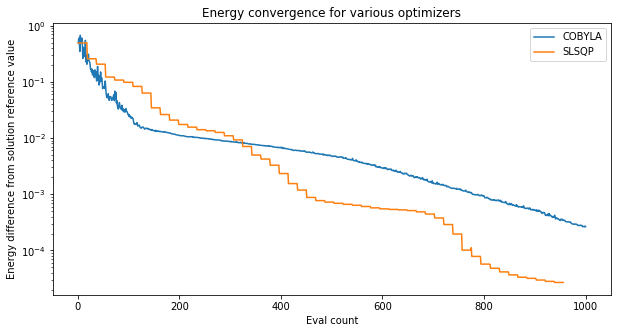

In [17]:
plt.figure(figsize=(10,5))
for i in range(len(optimizers)):
    plt.plot(converge_cnts[i], abs(ref - converge_vals[i]), label=optimizers[i].__name__)
plt.xlabel('Eval count')
plt.ylabel('Energy difference from solution reference value')
plt.title('Energy convergence for various optimizers')
plt.yscale('log')
plt.legend(loc='upper right')

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright